#In-Head Rotary Positional Embedding (RoPE) in DeepSeek-V3 and DeepSeek-R1


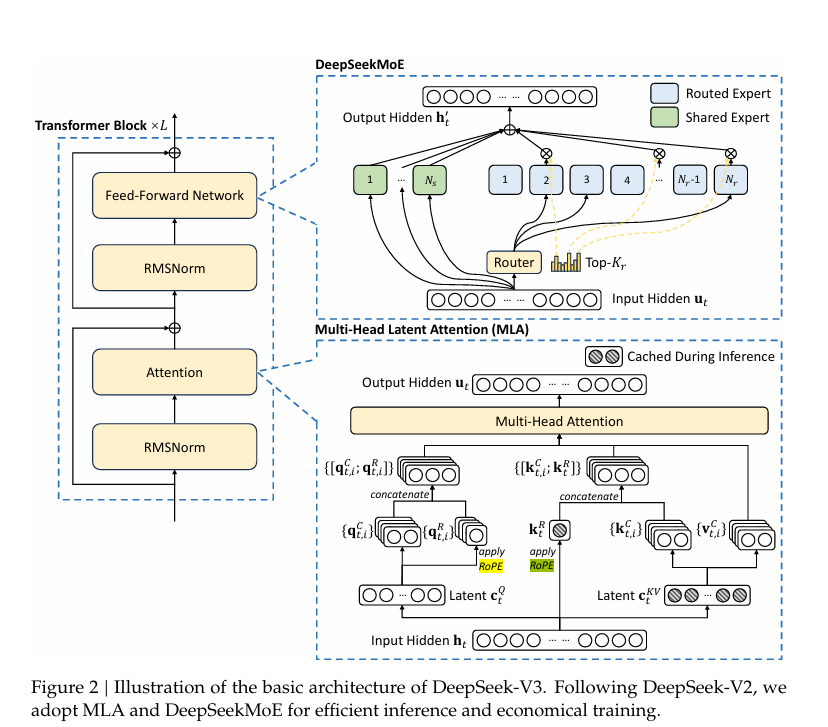

#In-Head Rotary Positional Embedding (RoPE) in DeepSeek-V3 and DeepSeek-R1

Copyright 2025, Denis Rothman
   
Reference for this educational notebook drawn from the *DeepSeek-V3 Technical Report*:
https://arxiv.org/abs/2412.19437

Beyond the pure-RL mechanics in DeepSeek-R1, DeepSeek-V3 also pioneers a more integrated approach to positional information inside its attention layers. This is quite another leap forward in DeepSeek's approach to generative AI model training.

### Traditional Positional Embeddings
In a standard Transformer, position vectors (e.g. sinusoidal or learned) are **added** to token embeddings at the bottom of the model. This means that attention heads see only the sum:  
```python
X_pos = X_tokens + PE_positions
Q = X_pos @ W_Q
K = X_pos @ W_K
````

### Rotary Positional Embedding inside MLA

DeepSeek-V3’s **Multi-Head Latent Attention (MLA)** instead **interleaves** position rotations *after* projecting into key/query subspaces. Concretely, for each token hidden state h_t:

```text
c_KV_t = W_DKV · h_t        # low-rank compressed content
k_C_t = W_UK · c_KV_t       # content keys per head
k_R_t = RoPE(W_KR · h_t)    # *rotary* positions, inside attention head :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
k_t,i = [k_C_{t,i} ; k_R_t]  # concat content + rotary
```

Similarly for queries:

```text
q_C_t = W_UQ · (W_DQ · h_t)
q_R_t = RoPE(W_QR · (W_DQ · h_t))  # rotary positions in query subspace :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
q_t,i = [q_C_{t,i} ; q_R_{t,i}]
```

* **Why this matters**:

  1. **No separate PE matrix**—position lives *inside* the head, enabling richer interactions per head.
  2. **Reduced KV cache**—only the small rotary part needs to be stored alongside compressed content.
  3. **Compatibility with long contexts**—RoPE naturally extends to arbitrarily long sequences without changing the base embeddings.

In the cell below, we’ll build a tiny toy to compare (a) additive sinusoidal PEs vs. (b) in-head RoPE, and inspect how each affects the self-attention scores.

This educational example shows how the same base inputs yield **different attention patterns** when you bake positional structure **inside** each head via RoPE, just as DeepSeek-V3 does in its MLA blocks.


# An educational example in code

In [ ]:
import numpy as np

def sinusoidal_pe(seq_len, dim):
    """Create standard sinusoidal positional embeddings (seq_len × dim)."""
    pe = np.zeros((seq_len, dim))
    pos = np.arange(seq_len)[:, None]
    i = np.arange(dim)[None, :]
    angle = pos / np.power(10000, (2 * (i//2)) / dim)
    pe[:, 0::2] = np.sin(angle[:, 0::2])
    pe[:, 1::2] = np.cos(angle[:, 1::2])
    return pe

def apply_rope(x, seq_len):
    """
    Apply a very simple RoPE: rotates each pair of dims (2i,2i+1) by angle = pos/10000^(2i/d).
    x: (seq_len, dim)
    """
    dim = x.shape[1]
    pe = sinusoidal_pe(seq_len, dim)
    # split into pairs and rotate: [x2i, x2i+1] -> [x2i*cos + x2i+1*sin, -x2i*sin + x2i+1*cos]
    x_rot = x.copy()
    for pos in range(seq_len):
        for i in range(0, dim, 2):
            cos, sin = pe[pos, i+1], pe[pos, i]
            x2, x2p1 = x[pos, i], x[pos, i+1]
            x_rot[pos, i]   =  x2 * cos - x2p1 * sin
            x_rot[pos, i+1] =  x2 * sin + x2p1 * cos
    return x_rot

# Toy inputs
seq_len, dim = 5, 8
np.random.seed(0)
X = np.random.randn(seq_len, dim)

# 1) Standard additive PE
PE = sinusoidal_pe(seq_len, dim)
Q_std = (X + PE) @ np.random.randn(dim, dim)
K_std = (X + PE) @ np.random.randn(dim, dim)
attn_std = Q_std @ K_std.T

# 2) In-head RoPE
# project then rotate inside head
WQ = np.random.randn(dim, dim)
WK = np.random.randn(dim, dim)
Q_proj = X @ WQ
K_proj = X @ WK
Q_rope = apply_rope(Q_proj, seq_len)
K_rope = apply_rope(K_proj, seq_len)
attn_rope = Q_rope @ K_rope.T

print("Self-attention logits with additive PE:\n", np.round(attn_std, 2))
print("\nSelf-attention logits with in-head RoPE:\n", np.round(attn_rope, 2))


Self-attention logits with additive PE:
 [[   5.18   21.08   -3.05  -10.38   78.65]
 [  29.21   18.84   34.2    -6.67  -32.46]
 [  51.29   21.79   72.2   -30.13 -136.24]
 [  17.46    2.67   31.26    1.95  -39.76]
 [   8.1    -9.28   13.7    53.77  -57.34]]

Self-attention logits with in-head RoPE:
 [[-21.41  -4.69   1.4    3.05 -22.25]
 [ -6.81  -1.16 -15.13  -0.92  -9.43]
 [-13.99 -11.3   50.53 -13.93  16.57]
 [ 18.43  -5.65  49.7   31.64  -6.53]
 [ -9.45  -6.99  18.73   2.87 -20.1 ]]


# Additional information


## Rotary Positional Embedding (RoPE) inside Attention Heads

In DeepSeek-V3, positional information is no longer injected via a separate embedding layer at the bottom of the Transformer. Instead, **RoPE rotates queries and keys directly inside each attention head**, yielding richer, more flexible position–content interactions.

### 1. Traditional vs. In-Head Embedding

**Traditional**  
```text
X_pos = X_tokens + PE_positions
Q = X_pos · W_Q
K = X_pos · W_K
````

A standalone positional‐embedding tensor is **added** to the token embeddings before any projections.

**DeepSeek-V3 (MLA)**

1. **Compress content**

   ```text
   c_KV_t = W_DKV · h_t  
   [k_C_{t,1}; …; k_C_{t,n_h}] = W_UK · c_KV_t
   ```
2. **Decoupled rotary component**

   ```text
   k_R_t = RoPE(W_KR · h_t)      RoPE applies a rotation per head based on token position :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
   q_R_t = RoPE(W_QR · (W_DQ · h_t))  similarly for queries :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
   ```
3. **Concatenate per head**

   ```text
   k_{t,i} = [\,k_C_{t,i}; k_R_t\,]  
   q_{t,i} = [\,q_C_{t,i}; q_R_{t,i}\,]
   ```

By embedding positions **inside** the head subspaces, each head learns to mix content and position jointly, rather than treating position as an afterthought.

### 2. Key Benefits

* **Eliminates a separate PE matrix**
  No need to store or add a large positional‐embedding table—positions live inherently in each head.
* **Reduced KV cache**
  Only the small rotary component (k\_R) plus compressed content (c\_KV) must be cached for inference, cutting memory overhead .
* **Seamless long-context support**
  RoPE’s rotation scales naturally to arbitrary sequence lengths without retraining or resizing a PE table.
* **Richer position–content interaction**
  Heads can learn distinct rotation patterns, enabling head-specific sensitivity to relative and absolute positions.

---

This in-head RoPE design is a core innovation in DeepSeek-V3’s Multi-Head Latent Attention, empowering more efficient, flexible, and scalable handling of positional information directly within each attention head.
